# Sommaire
* [Introduction](#introduction)
* [I) Importation des données](#i)
* [II) 1er modèle : Approche simple](#ii)
    * [1) ModelCheckpoint et EarlyStopping = val_loss](#ii1)
    * [2) ModelCheckpoint et EarlyStopping = val_accuracy](#ii2)
* [III) 2ème modèle : Approche par ImageDataGenerator avec data augmentation](#iii)
    * [1) ModelCheckpoint et EarlyStopping = val_loss](#iii1)
    * [2) ModelCheckpoint et EarlyStopping = val_accuracy](#iii2)
* [IV) 3ème modèle : Approche par Dataset sans data augmentation](#iv)
    * [1) ModelCheckpoint et EarlyStopping = val_loss](#iv1)
    * [2) ModelCheckpoint et EarlyStopping = val_accuracy](#iv2)
* [V) 4ème modèle : Approche par Dataset avec data augmentation](#v)
    * [1) ModelCheckpoint et EarlyStopping = val_loss](#v1)
    * [2) ModelCheckpoint et EarlyStopping = val_accuracy](#v2)
* [VI) Résultats](#vi)
* [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>
L'étude de faisabilité étant concluante, dans ce notebook nous allons désormais tenter des approches de classification supervisée à partir des images :
- Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée.
- Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images.
- Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation.
- Une approche par DataSet, avec data augmentation intégrée au modèle : layer en début de modèle.

# I) Importation des données <a class="anchor" id="i"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)

Mounted at /content/drive


In [2]:
data_desc = pd.read_csv('/content/drive/MyDrive/data_desc.csv')
data_desc[:5]

,uniq_id,product_name,image,description,categorie_1,description_propre,description_token,description_stem,description_lem,description_final
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,key features elegance polyester multicolor abs...,"['key', 'features', 'elegance', 'polyester', '...","['key', 'featur', 'eleg', 'polyest', 'multicol...","['key', 'feature', 'elegance', 'polyester', 'm...","['key', 'elegance', 'polyester', 'multicolor',..."
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,specifications sathiyas cotton bath towel 3 ba...,"['specifications', 'sathiyas', 'cotton', 'bath...","['specif', 'sathiya', 'cotton', 'bath', 'towel...","['specification', 'sathiyas', 'cotton', 'bath'...","['specification', 'cotton', 'bath', 'towel', '..."
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,key features eurospa cotton terry face towel s...,"['key', 'features', 'eurospa', 'cotton', 'terr...","['key', 'featur', 'eurospa', 'cotton', 'terri'...","['key', 'feature', 'eurospa', 'cotton', 'terry...","['key', 'cotton', 'terry', 'face', 'towel', 's..."
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,key features santosh royal fashion cotton prin...,"['key', 'features', 'santosh', 'royal', 'fashi...","['key', 'featur', 'santosh', 'royal', 'fashion...","['key', 'feature', 'santosh', 'royal', 'fashio...","['key', 'royal', 'fashion', 'cotton', 'printed..."
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,key features jaipur print cotton floral king s...,"['key', 'features', 'jaipur', 'print', 'cotton...","['key', 'featur', 'jaipur', 'print', 'cotton',...","['key', 'feature', 'jaipur', 'print', 'cotton'...","['key', 'jaipur', 'print', 'cotton', 'floral',..."


In [3]:
data = data_desc[['image', 'categorie_1']]
data[:5]

,image,categorie_1
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


# II) 1er modèle : Approche simple <a class="anchor" id="ii"></a>

In [4]:
#On définit X
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image

#Pour charger des images de grande taille
Image.MAX_IMAGE_PIXELS = None

#Liste vide pour enregistrer les images préparées
images_prep = []

#Boucle sur chaque image dans le dossier
for fichier_image in data['image']:
    #Chemin où sont enregistrées les images
    fichier_image_path = os.path.join("/content/drive/MyDrive/Images", fichier_image)

    #On redimensionne en 224x224
    image = load_img(fichier_image_path, target_size=(224, 224))

    #On convertit en array pour pouvoir manipuler
    image_array = img_to_array(image)

    #On rééquilibre les couleurs RGB
    image_rgb = preprocess_input(image_array)

    #On ajoute à la liste
    images_prep.append(image_rgb)

X = np.array(images_prep)
print(X.shape)

(1050, 224, 224, 3)


In [5]:
#On définit y
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
y = ohe.fit_transform(data[['categorie_1']])
print(y.shape)

(1050, 7)


In [6]:
#On sépare en jeu d'entraînement (80%), de validation (10%) et de test (10%)
#On utilise la stratification lors de la séparation pour maintenir une distribution uniforme dans tous les sous-ensembles
from sklearn.model_selection import train_test_split

X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("X_train :", X_train.shape)
print("X_val :", X_val.shape)
print("X_test :", X_val.shape)

X_train : (840, 224, 224, 3)
X_val : (105, 224, 224, 3)
X_test : (105, 224, 224, 3)


In [7]:
#On définit une fonction pour créer le modèle
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

def create_model_fct() :
    #On récupère le modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    #Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    #On récupère la sortie de ce réseau
    x = model0.output
    #On complète le modèle
    x = GlobalAveragePooling2D()(x) #Réduit la dimensionnalité de l'entrée
    x = Dense(256, activation='relu')(x) #Couche dense (fully-connected) avec 256 neurones
    x = Dropout(0.5)(x) #Couche d'abandon pour éviter le surapprentissage, désactive aléatoirement 50% des neurones lors de l'entraînement
    predictions = Dense(7, activation='softmax')(x) #Dernière couche avec 7 neurones (7 classes à prédire)

    #On définit le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    #On compile
    #categorical_crossentropy = fonction de perte couramment utilisée pour les problèmes de classification multiclasse où les étiquettes sont one-hot encoded
    #rmsprop = optimiseur qui ajuste dynamiquement le taux d'apprentissage en fonction de la moyenne mobile du carré des gradients (j'ai testé adam également, convergence plus rapide mais résultats moins bons)
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model

Je décide d'entraîner 2 modèles pour tester 2 critères de surveillance différents et mesurer leur impact.
## 1) ModelCheckpoint et EarlyStopping = val_loss <a class="anchor" id="ii1"></a>

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Création du modèle
model1_vl = create_model_fct()

#Création du callback
#On cherche à minimiser la perte
model1_vl_save_path = "/content/drive/MyDrive/model1_vl_best_weights.keras"
checkpoint = ModelCheckpoint(model1_vl_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #Arrête l'entraînement si la performance ne s'améliore pas après 5 epochs
callbacks_list = [checkpoint, es]

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [9]:
#On entraîne le modèle
import time
from datetime import timedelta
batch_size = 16 #On conserve ce batch_size pour tout le notebook

start_time = time.time()
history1_vl = model1_vl.fit(X_train, y_train, epochs=50, batch_size=batch_size, callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
end_time = time.time()

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 4.6483 - accuracy: 0.5333
Epoch 1: val_loss improved from inf to 1.10023, saving model to /content/drive/MyDrive/model1_vl_best_weights.keras
53/53 [==============================] - 22s 397ms/step - loss: 4.6483 - accuracy: 0.5333 - val_loss: 1.1002 - val_accuracy: 0.7810
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 1.5901 - accuracy: 0.7440
Epoch 2: val_loss improved from 1.10023 to 1.03526, saving model to /content/drive/MyDrive/model1_vl_best_weights.keras
53/53 [==============================] - 18s 332ms/step - loss: 1.5901 - accuracy: 0.7440 - val_loss: 1.0353 - val_accuracy: 0.7905
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 0.9137 - accuracy: 0.7952
Epoch 3: val_loss improved from 1.03526 to 0.90150, saving model to /content/drive/MyDrive/model1_vl_best_weights.keras
53/53 [==============================] - 18s 334ms/step - loss: 0.9137 - accuracy: 0.7952 - val_lo

In [10]:
#On enregistre le temps d'entraînement et le nombre d'epochs
durée1_vl = end_time - start_time
durée1_vl = str(timedelta(seconds=int(durée1_vl)))
print(f"Temps d'entraînement : {durée1_vl}")
nb_epochs1_vl = es.stopped_epoch
print(f"Nombre d'epochs : {nb_epochs1_vl}")

Temps d'entraînement : 0:03:16
Nombre d'epochs : 10


In [11]:
#On définit une fonction pour enregistrer les résultats
#Liste vide pour commencer
resultats = []

def evaluation_et_resultats(model, save_path, model_name, nb_epochs, temps_train):
    #On charge les poids du modèle
    model.load_weights(save_path)

    #On évalue le jeu de validation
    loss_val, accuracy_val = model.evaluate(X_val, y_val, verbose=1)

    #Puis le jeu de test
    loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=1)

    #On ajoute les résultats à la liste
    resultats.append({'modèles': model_name,
                      'nb_epochs': nb_epochs,
                      'loss_val': loss_val,
                      'accuracy_val': accuracy_val,
                      'loss_test': loss_test,
                      'accuracy_test': accuracy_test,
                      'temps_train': temps_train})

In [12]:
#On applique
evaluation_et_resultats(model1_vl, model1_vl_save_path, "model1_vl", nb_epochs1_vl, durée1_vl)

4/4 [==============================] - 2s 434ms/step - loss: 1.9373 - accuracy: 0.7714


In [13]:
!pip install plot_keras_history

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of plot-keras-history to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.36-py3-none-any.whl size=9216 sha256=c341fcfeaefc6581947d903bfc14619d81a1039878d29d94e0951ac79c320283
  Stored in directory: /root/.cache/pip/wheels/f2/3d/9d/f6f3bbee314c8cc369277b721b41ac4ab8b790df199ed7d1ad
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.1.0-py3-none-any.whl size=323542 sha256=4fe8676fc666baf2fa72f40c4ac4d5b06ca49c8fa0e1f3bb3d4a2c6f8aa8081d
  Stored in directory: /root/.cache/pip/wheels/79/89/fb/06b588eac70ca5d414815235b4443fa867402a399f76d1

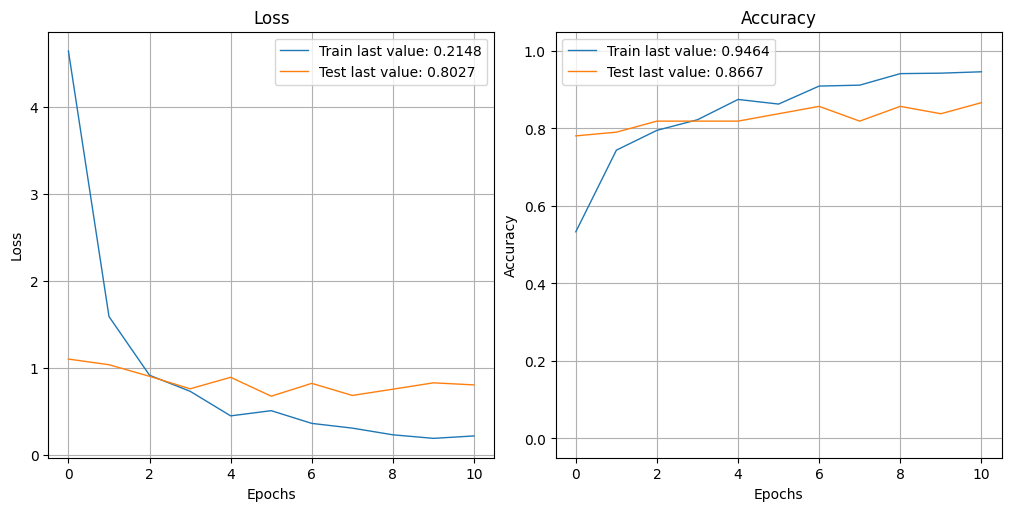

In [14]:
#Pour voir l'évolution de la perte et de l'accuracy des jeux d'entraînement et de validation en fonction de l'epoch
from plot_keras_history import show_history, plot_history

show_history(history1_vl)
plot_history(history1_vl, path="standard.png")
plt.close()

In [15]:
#On convertit les labels en indices de classes
y_test_num1 = np.argmax(y_test, axis=1)
print(y_test_num1)
print()

#On prédit les catégories sur le jeu de test
y_pred1_vl = np.argmax(model1_vl.predict(X_test), axis=1)
print(y_pred1_vl)

[1 6 2 1 2 0 2 0 6 1 6 2 3 1 4 4 4 6 6 4 5 6 1 6 0 1 1 4 0 2 1 6 3 2 2 5 6
 3 2 5 4 0 6 3 0 3 0 2 4 3 2 4 5 5 6 1 5 4 1 3 0 3 0 4 3 2 5 4 6 3 1 4 0 3
 1 4 6 5 0 2 2 2 5 0 0 1 5 0 3 3 4 5 5 1 3 1 0 4 5 2 6 6 5 3 5]

4/4 [==============================] - 2s 474ms/step
[1 6 5 1 5 5 2 0 6 1 6 2 3 1 4 4 0 6 6 4 5 6 1 6 4 1 1 0 4 2 6 6 3 2 2 5 6
 3 2 5 4 0 6 3 4 0 0 2 4 3 6 4 5 1 6 1 5 0 1 5 4 3 0 4 3 2 5 4 6 3 1 4 4 6
 1 4 6 5 0 6 2 2 5 0 0 1 3 4 2 3 4 5 5 1 3 3 4 4 5 3 6 6 5 3 5]


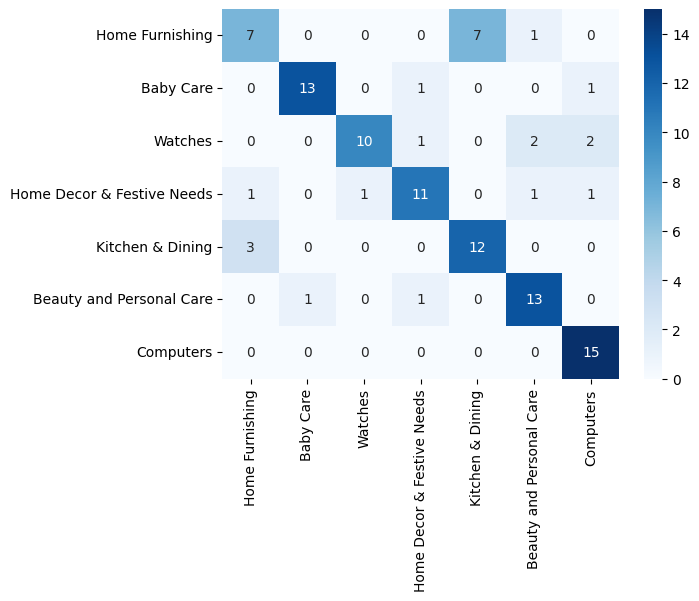

                            precision    recall  f1-score   support

           Home Furnishing       0.64      0.47      0.54        15
                 Baby Care       0.93      0.87      0.90        15
                   Watches       0.91      0.67      0.77        15
Home Decor & Festive Needs       0.79      0.73      0.76        15
          Kitchen & Dining       0.63      0.80      0.71        15
  Beauty and Personal Care       0.76      0.87      0.81        15
                 Computers       0.79      1.00      0.88        15

                  accuracy                           0.77       105
                 macro avg       0.78      0.77      0.77       105
              weighted avg       0.78      0.77      0.77       105



In [16]:
#Heatmap et classification report sur le jeu de test
from sklearn import metrics

conf_mat1_vl = metrics.confusion_matrix(y_test_num1, y_pred1_vl)
df_cm1_vl = pd.DataFrame(conf_mat1_vl, index=[label for label in data['categorie_1'].unique()], columns=[label for label in data['categorie_1'].unique()])
sns.heatmap(df_cm1_vl, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report1_vl = metrics.classification_report(y_test_num1, y_pred1_vl, target_names=data['categorie_1'].unique())
print(report1_vl)

## 2) ModelCheckpoint et EarlyStopping = val_accuracy <a class="anchor" id="ii2"></a>

In [17]:
#Création du modèle
model1_va = create_model_fct()

#Création du callback
#On cherche à maximiser l'accuracy
model1_va_save_path = "/content/drive/MyDrive/model1_va_best_weights.keras"
checkpoint = ModelCheckpoint(model1_va_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) #Arrête l'entraînement si la performance ne s'améliore pas après 5 epochs
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [18]:
#On entraîne le modèle
start_time = time.time()
history1_va = model1_va.fit(X_train, y_train, epochs=50, batch_size=batch_size, callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
end_time = time.time()

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 3.9270 - accuracy: 0.5476
Epoch 1: val_accuracy improved from -inf to 0.77143, saving model to /content/drive/MyDrive/model1_va_best_weights.keras
53/53 [==============================] - 22s 407ms/step - loss: 3.9270 - accuracy: 0.5476 - val_loss: 1.2550 - val_accuracy: 0.7714
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 1.4863 - accuracy: 0.7369
Epoch 2: val_accuracy improved from 0.77143 to 0.79048, saving model to /content/drive/MyDrive/model1_va_best_weights.keras
53/53 [==============================] - 18s 334ms/step - loss: 1.4863 - accuracy: 0.7369 - val_loss: 1.0283 - val_accuracy: 0.7905
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 0.9011 - accuracy: 0.8012
Epoch 3: val_accuracy improved from 0.79048 to 0.80952, saving model to /content/drive/MyDrive/model1_va_best_weights.keras
53/53 [==============================] - 18s 339ms/step - loss: 0.9011 - accuracy: 0.

In [19]:
#On enregistre le temps d'entraînement et le nombre d'epochs
durée1_va = end_time - start_time
durée1_va = str(timedelta(seconds=int(durée1_va)))
print(f"Temps d'entraînement : {durée1_va}")
nb_epochs1_va = es.stopped_epoch
print(f"Nombre d'epochs : {nb_epochs1_va}")

Temps d'entraînement : 0:04:12
Nombre d'epochs : 13


In [20]:
#On enregistre les résultats
evaluation_et_resultats(model1_va, model1_va_save_path, "model1_va", nb_epochs1_va, durée1_va)

4/4 [==============================] - 2s 437ms/step - loss: 1.7548 - accuracy: 0.8095


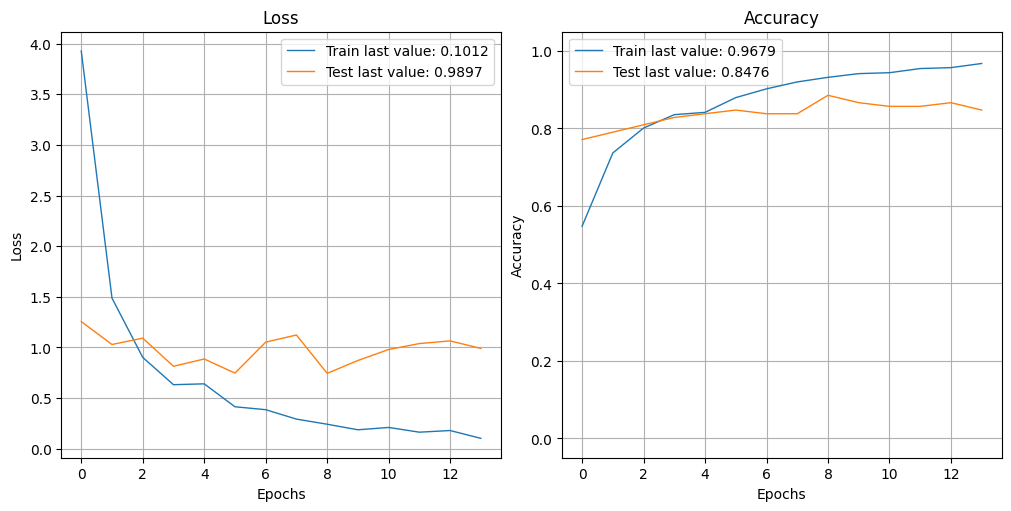

In [21]:
#Pour voir l'évolution de la perte et de l'accuracy des jeux d'entraînement et de validation en fonction de l'epoch
show_history(history1_va)
plot_history(history1_va, path="standard.png")
plt.close()

In [22]:
#On prédit les catégories sur le jeu de test
y_pred1_va = np.argmax(model1_va.predict(X_test), axis=1)
print(y_pred1_va)

4/4 [==============================] - 2s 442ms/step
[1 6 2 1 5 5 2 0 6 1 6 2 3 1 4 4 0 6 6 4 5 6 1 6 4 1 1 0 4 2 3 3 3 2 2 5 6
 3 2 5 4 0 3 3 4 0 0 2 4 3 3 4 5 1 6 1 5 4 1 5 4 3 0 4 3 2 5 4 6 3 1 4 4 3
 1 4 6 5 0 6 2 2 5 0 0 1 5 0 2 3 4 5 5 1 3 3 0 4 5 3 6 6 5 3 5]


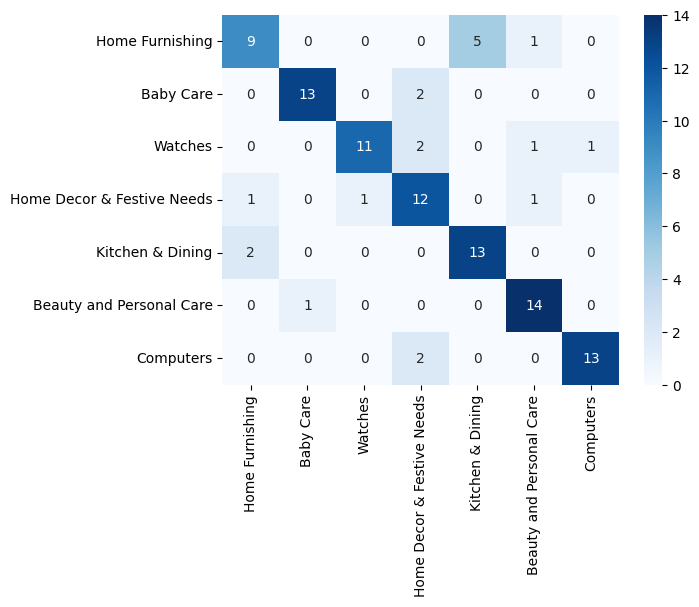

                            precision    recall  f1-score   support

           Home Furnishing       0.75      0.60      0.67        15
                 Baby Care       0.93      0.87      0.90        15
                   Watches       0.92      0.73      0.81        15
Home Decor & Festive Needs       0.67      0.80      0.73        15
          Kitchen & Dining       0.72      0.87      0.79        15
  Beauty and Personal Care       0.82      0.93      0.87        15
                 Computers       0.93      0.87      0.90        15

                  accuracy                           0.81       105
                 macro avg       0.82      0.81      0.81       105
              weighted avg       0.82      0.81      0.81       105



In [23]:
#Heatmap et classification report sur le jeu de validation
conf_mat1_va = metrics.confusion_matrix(y_test_num1, y_pred1_va)
df_cm1_va = pd.DataFrame(conf_mat1_va, index=[label for label in data['categorie_1'].unique()], columns=[label for label in data['categorie_1'].unique()])
sns.heatmap(df_cm1_va, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report1_va = metrics.classification_report(y_test_num1, y_pred1_va, target_names=data['categorie_1'].unique())
print(report1_va)

On enchaîne avec data augmentation.
# III) 2ème modèle : Approche par ImageDataGenerator avec data augmentation <a class="anchor" id="iii"></a>

In [24]:
#On sépare en jeu d'entraînement, validation et test
data_train, data_temp = train_test_split(data, test_size=0.2, random_state=42, stratify=data['categorie_1'])
data_val, data_test = train_test_split(data_temp, test_size=0.5, random_state=42, stratify=data_temp['categorie_1'])

print("data_train :", data_train.shape)
print("data_val :", data_val.shape)
print("data_test :", data_val.shape)

data_train : (840, 2)
data_val : (105, 2)
data_test : (105, 2)


In [25]:
#On définit une fonction pour créer des data flows (générateurs de flux de données)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_flow_fct(data, datagen, shuffle=True) :
    data_flow = datagen.flow_from_dataframe(data, directory='/content/drive/MyDrive/Images',
                                x_col='image', y_col='categorie_1',
                                weight_col=None, target_size=(224, 224),
                                class_mode='categorical', batch_size=batch_size,
                                shuffle=shuffle, seed=42)
    return data_flow

In [26]:
#On créé l'ImageDataGenerator avec augmentation pour l'entraînement
datagen_train = ImageDataGenerator(rotation_range=36, #20% de rotation (de -36 à +36 degrés)
                                   width_shift_range=0.2, #20% de translation horizontale
                                   height_shift_range=0.2, #20% de translation verticale
                                   horizontal_flip=True, #Flip horizontal
                                   zoom_range=0.2, #20% de zoom
                                   preprocessing_function=preprocess_input)

#Sans augmentation pour la validation et le test
datagen_val_test = ImageDataGenerator(preprocessing_function=preprocess_input)

In [27]:
#On applique pour créer les flux de données
train_flow = data_flow_fct(data_train, datagen_train, shuffle=True) #Avec data augmentation et mélange
val_flow = data_flow_fct(data_val, datagen_val_test, shuffle=False) #Sans data augmentation ni mélange
test_flow = data_flow_fct(data_test, datagen_val_test, shuffle=False) #Sans data augmentation ni mélange

Found 840 validated image filenames belonging to 7 classes.
Found 105 validated image filenames belonging to 7 classes.
Found 105 validated image filenames belonging to 7 classes.


Une nouvelle fois, nous entraînons 2 modèles pour tester 2 critères de surveillance différents
## 1) ModelCheckpoint et EarlyStopping = val_loss <a class="anchor" id="iii1"></a>

In [28]:
#Création du modèle
model2_vl = create_model_fct()

#Création du callback
#On cherche à minimiser la perte
model2_vl_save_path = "/content/drive/MyDrive/model2_vl_best_weights.keras"
checkpoint = ModelCheckpoint(model2_vl_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #Arrête l'entraînement si la performance ne s'améliore pas après 5 epochs
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
#On entraîne le modèle
start_time = time.time()
history2_vl = model2_vl.fit(train_flow, epochs=50, batch_size=batch_size, callbacks=callbacks_list, validation_data=val_flow, verbose=1)
end_time = time.time()

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 3.5212 - accuracy: 0.5071
Epoch 1: val_loss improved from inf to 1.79012, saving model to /content/drive/MyDrive/model2_vl_best_weights.keras
53/53 [==============================] - 35s 640ms/step - loss: 3.5212 - accuracy: 0.5071 - val_loss: 1.7901 - val_accuracy: 0.7143
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 1.4821 - accuracy: 0.6810
Epoch 2: val_loss improved from 1.79012 to 1.37916, saving model to /content/drive/MyDrive/model2_vl_best_weights.keras
53/53 [==============================] - 31s 584ms/step - loss: 1.4821 - accuracy: 0.6810 - val_loss: 1.3792 - val_accuracy: 0.7524
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 0.9714 - accuracy: 0.7310
Epoch 3: val_loss improved from 1.37916 to 1.24321, saving model to /content/drive/MyDrive/model2_vl_best_weights.keras
53/53 [==============================] - 31s 584ms/step - loss: 0.9714 - accuracy: 0.7310 - val_lo

In [30]:
#On enregistre le temps d'entraînement et le nombre d'epochs
durée2_vl = end_time - start_time
durée2_vl = str(timedelta(seconds=int(durée2_vl)))
print(f"Temps d'entraînement : {durée2_vl}")
nb_epochs2_vl = es.stopped_epoch
print(f"Nombre d'epochs : {nb_epochs2_vl}")

Temps d'entraînement : 0:04:39
Nombre d'epochs : 8


In [31]:
#Il faut légèrement modifier la fonction pour l'enregistrement des résultats
def evaluation_et_resultats(model, save_path, model_name, nb_epochs, temps_train):
    #On charge les poids du modèle
    model.load_weights(save_path)

    #On évalue le jeu de validation
    loss_val, accuracy_val = model.evaluate(val_flow, verbose=1)

    #Puis le jeu de test
    loss_test, accuracy_test = model.evaluate(test_flow, verbose=1)

    #On ajoute les résultats à la liste
    resultats.append({'modèles': model_name,
                      'nb_epochs': nb_epochs,
                      'loss_val': loss_val,
                      'accuracy_val': accuracy_val,
                      'loss_test': loss_test,
                      'accuracy_test': accuracy_test,
                      'temps_train': temps_train})

In [32]:
#On applique
evaluation_et_resultats(model2_vl, model2_vl_save_path, "model2_vl", nb_epochs2_vl, durée2_vl)

7/7 [==============================] - 2s 325ms/step - loss: 0.9265 - accuracy: 0.7619


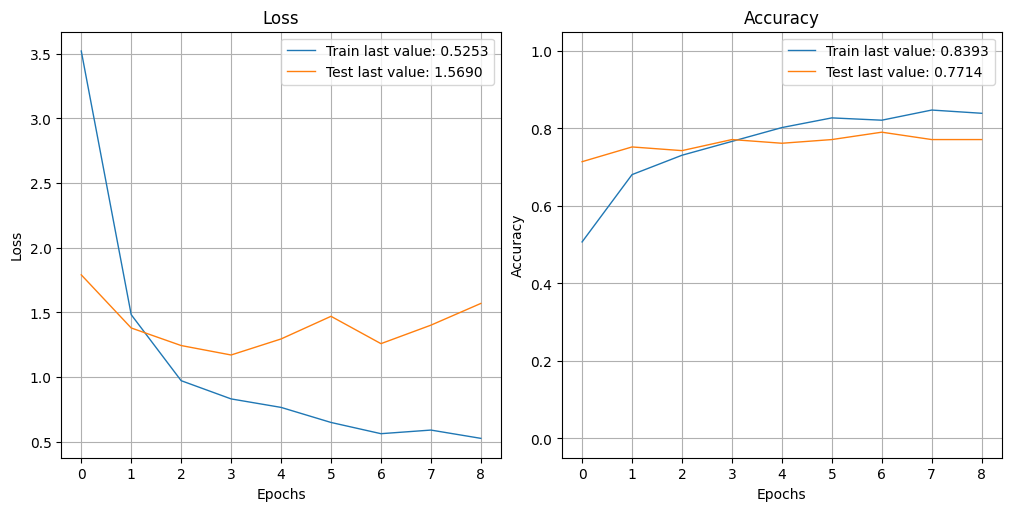

In [33]:
#Pour voir l'évolution de la perte et de l'accuracy des jeux d'entraînement et de validation en fonction de l'epoch
show_history(history2_vl)
plot_history(history2_vl, path="standard.png")
plt.close()

In [34]:
#On récupère les étiquettes des classes du test_flow
y_test_num2 = test_flow.classes
print(y_test_num2)

#On prédit les catégories sur le jeu de test
y_pred2_vl = np.argmax(model2_vl.predict(test_flow), axis=1)
print(y_pred2_vl)

[5, 0, 4, 5, 4, 6, 4, 6, 0, 5, 0, 4, 3, 5, 2, 2, 2, 0, 0, 2, 1, 0, 5, 0, 6, 5, 5, 2, 6, 4, 5, 0, 3, 4, 4, 1, 0, 3, 4, 1, 2, 6, 0, 3, 6, 3, 6, 4, 2, 3, 4, 2, 1, 1, 0, 5, 1, 2, 5, 3, 6, 3, 6, 2, 3, 4, 1, 2, 0, 3, 5, 2, 6, 3, 5, 2, 0, 1, 6, 4, 4, 4, 1, 6, 6, 5, 1, 6, 3, 3, 2, 1, 1, 5, 3, 5, 6, 2, 1, 4, 0, 0, 1, 3, 1]
7/7 [==============================] - 3s 316ms/step
[5 0 4 5 0 6 4 6 0 5 0 4 3 5 2 2 2 0 4 4 1 4 5 5 2 5 5 2 6 4 5 0 3 0 4 3 3
 3 4 1 2 2 0 3 6 3 6 4 5 2 4 2 6 1 0 5 1 2 5 3 6 0 6 2 3 4 1 2 0 4 5 4 6 3
 5 3 5 2 6 4 4 4 1 6 6 5 1 6 3 5 5 1 1 5 3 5 3 2 4 4 0 2 1 5 1]


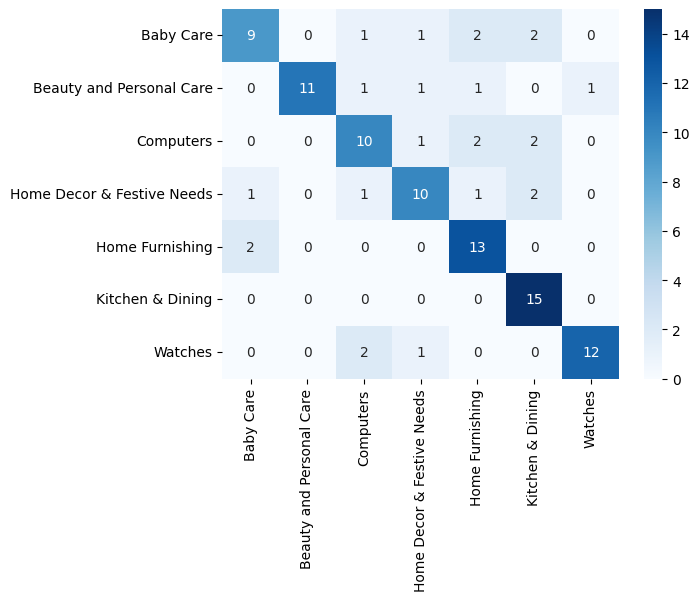

                            precision    recall  f1-score   support

                 Baby Care       0.75      0.60      0.67        15
  Beauty and Personal Care       1.00      0.73      0.85        15
                 Computers       0.67      0.67      0.67        15
Home Decor & Festive Needs       0.71      0.67      0.69        15
           Home Furnishing       0.68      0.87      0.76        15
          Kitchen & Dining       0.71      1.00      0.83        15
                   Watches       0.92      0.80      0.86        15

                  accuracy                           0.76       105
                 macro avg       0.78      0.76      0.76       105
              weighted avg       0.78      0.76      0.76       105



In [35]:
#Heatmap et classification report sur le jeu de test
conf_mat2_vl = metrics.confusion_matrix(y_test_num2, y_pred2_vl)
df_cm2_vl = pd.DataFrame(conf_mat2_vl, index=[label for label in list(test_flow.class_indices.keys())], columns=[label for label in list(test_flow.class_indices.keys())])
sns.heatmap(df_cm2_vl, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report2_vl = metrics.classification_report(y_test_num2, y_pred2_vl, target_names=list(test_flow.class_indices.keys()))
print(report2_vl)

## 2) ModelCheckpoint et EarlyStopping = val_accuracy <a class="anchor" id="iii2"></a>

In [36]:
#Création du modèle
model2_va = create_model_fct()

#Création du callback
#On cherche à maximiser l'accuracy
model2_va_save_path = "/content/drive/MyDrive/model2_va_best_weights.keras"
checkpoint = ModelCheckpoint(model2_va_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) #Arrête l'entraînement si la performance ne s'améliore pas après 5 epochs
callbacks_list = [checkpoint, es]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [37]:
#On entraîne le modèle
start_time = time.time()
history2_va = model2_va.fit(train_flow, epochs=50, batch_size=batch_size, callbacks=callbacks_list, validation_data=val_flow, verbose=1)
end_time = time.time()

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 4.1176 - accuracy: 0.5107
Epoch 1: val_accuracy improved from -inf to 0.69524, saving model to /content/drive/MyDrive/model2_va_best_weights.keras
53/53 [==============================] - 34s 636ms/step - loss: 4.1176 - accuracy: 0.5107 - val_loss: 1.6716 - val_accuracy: 0.6952
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 1.4550 - accuracy: 0.6786
Epoch 2: val_accuracy improved from 0.69524 to 0.76190, saving model to /content/drive/MyDrive/model2_va_best_weights.keras
53/53 [==============================] - 30s 570ms/step - loss: 1.4550 - accuracy: 0.6786 - val_loss: 1.4454 - val_accuracy: 0.7619
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 1.0352 - accuracy: 0.7310
Epoch 3: val_accuracy did not improve from 0.76190
53/53 [==============================] - 31s 578ms/step - loss: 1.0352 - accuracy: 0.7310 - val_loss: 1.4867 - val_accuracy: 0.7429
Epoch 4/50
53/53 [========

In [38]:
#On enregistre le temps d'entraînement et le nombre d'epochs
durée2_va = end_time - start_time
durée2_va = str(timedelta(seconds=int(durée2_va)))
print(f"Temps d'entraînement : {durée2_va}")
nb_epochs2_va = es.stopped_epoch
print(f"Nombre d'epochs : {nb_epochs2_va}")

Temps d'entraînement : 0:10:13
Nombre d'epochs : 19


In [39]:
#On enregistre les résultats
evaluation_et_resultats(model2_va, model2_va_save_path, "model2_va", nb_epochs2_va, durée2_va)

7/7 [==============================] - 3s 329ms/step - loss: 0.9349 - accuracy: 0.8190


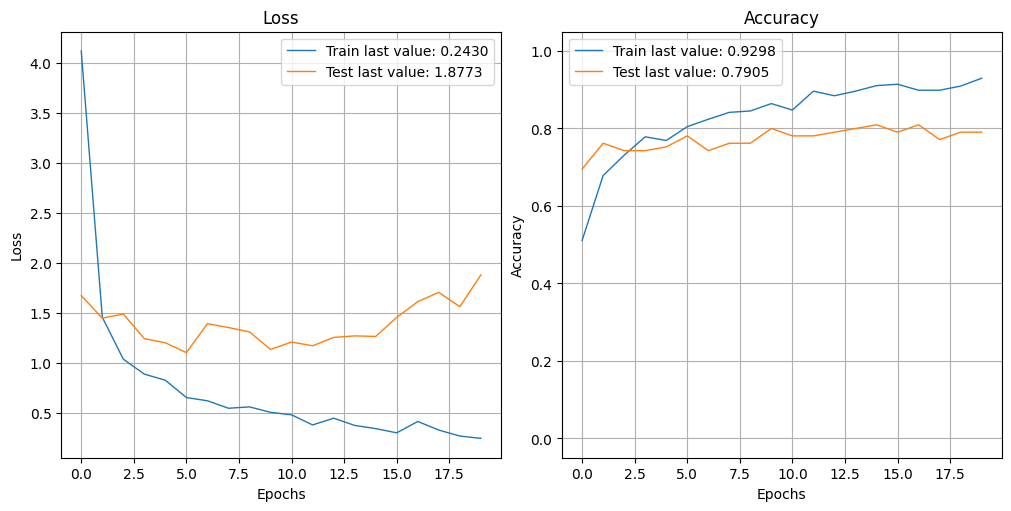

In [40]:
#Pour voir l'évolution de la perte et de l'accuracy des jeux d'entraînement et de validation en fonction de l'epoch
show_history(history2_va)
plot_history(history2_va, path="standard.png")
plt.close()

In [41]:
#On prédit les catégories sur le jeu de test
y_pred2_va = np.argmax(model2_va.predict(test_flow), axis=1)
print(y_pred2_va)

7/7 [==============================] - 3s 311ms/step
[5 0 4 5 0 6 4 6 0 2 0 4 3 5 2 2 2 0 0 4 1 4 5 0 6 5 5 2 6 4 5 0 3 4 4 3 0
 3 4 1 2 6 0 3 6 5 6 4 5 2 4 2 1 1 0 5 1 2 5 3 6 0 6 6 1 4 1 2 0 3 5 4 6 3
 0 3 5 1 6 3 4 4 1 6 6 5 1 6 3 3 2 1 1 5 3 5 6 2 4 4 0 5 1 5 1]


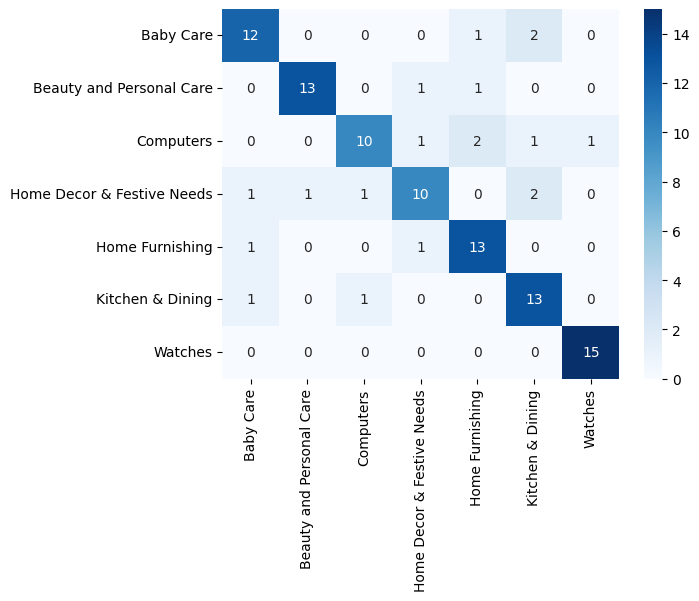

                            precision    recall  f1-score   support

                 Baby Care       0.80      0.80      0.80        15
  Beauty and Personal Care       0.93      0.87      0.90        15
                 Computers       0.83      0.67      0.74        15
Home Decor & Festive Needs       0.77      0.67      0.71        15
           Home Furnishing       0.76      0.87      0.81        15
          Kitchen & Dining       0.72      0.87      0.79        15
                   Watches       0.94      1.00      0.97        15

                  accuracy                           0.82       105
                 macro avg       0.82      0.82      0.82       105
              weighted avg       0.82      0.82      0.82       105



In [42]:
#Heatmap et classification report sur le jeu de test
conf_mat2_va = metrics.confusion_matrix(y_test_num2, y_pred2_va)
df_cm2_va = pd.DataFrame(conf_mat2_va, index=[label for label in list(test_flow.class_indices.keys())], columns=[label for label in list(test_flow.class_indices.keys())])
sns.heatmap(df_cm2_va, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report2_va = metrics.classification_report(y_test_num2, y_pred2_va, target_names=list(test_flow.class_indices.keys()))
print(report2_va)

On enchaîne avec une approche plus récente.
# IV) 3ème modèle : Approche par Dataset sans data augmentation <a class="anchor" id="iv"></a>

In [43]:
#On commence par créer un sous-dossier par catégorie
import shutil

#Dossier où sont stockées les images
base_dir = '/content/drive/MyDrive/Images'

#Un sous-dossier par catégorie
for categ in data['categorie_1'].unique():
    class_dir = os.path.join(base_dir, categ)
    os.makedirs(class_dir, exist_ok=True)

#On déplace les images dans les bons sous-dossiers
for _, ligne in data.iterrows():
    image_name = ligne['image']
    categ = ligne['categorie_1']
    src_path = os.path.join(base_dir, image_name)
    dest_path = os.path.join(base_dir, categ, image_name)
    shutil.move(src_path, dest_path)

In [44]:
#On va manoeuvrer un petit peu pour créer un dataset d'entraînement, de validation et de test
#Il n'existe pas de subset='test' donc on va utiliser la même logique que précédemment avec un jeu temporaire qu'on divise en 2
from tensorflow.keras.utils import image_dataset_from_directory

#On définit une fonction pour créer les datasets
def dataset_fct(base_dir, validation_split=0, data_type=None, shuffle=True) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    base_dir, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type)
    return dataset

#On créé le jeu d'entraînement (80%) et le jeu temporaire (20%)
train_dataset = dataset_fct(base_dir, validation_split=0.2, data_type='training', shuffle=True)
temp_dataset = dataset_fct(base_dir, validation_split=0.2, data_type='validation', shuffle=False)

Found 1050 files belonging to 7 classes.
Using 840 files for training.
Found 1050 files belonging to 7 classes.
Using 210 files for validation.


In [45]:
#On récupère les noms des classes
class_names = train_dataset.class_names

#Puis on divise le jeu temporaire pour garder les mêmes proportions que sur les autres modèles
def split_temp_dataset(temp_dataset, class_names):
    temp_images = []
    temp_labels = []
    for images, labels in temp_dataset:
        temp_images.extend(images.numpy())
        temp_labels.extend(labels.numpy())

    #On split
    val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

    #On convertit en datasets
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(16)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(16)

    #On définit class_names pour les datasets
    val_dataset.class_names = class_names
    test_dataset.class_names = class_names

    return val_dataset, test_dataset

#On applique
val_dataset, test_dataset = split_temp_dataset(temp_dataset, class_names)

On est reparti pour les 2 critères de surveillance.
## 1) ModelCheckpoint et EarlyStopping = val_loss <a class="anchor" id="iv1"></a>

In [46]:
#Création du modèle
model3_vl = create_model_fct()

#Création du callback
#On cherche à minimiser la perte
model3_vl_save_path = "/content/drive/MyDrive/model3_vl_best_weights.keras"
checkpoint = ModelCheckpoint(model3_vl_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #Arrête l'entraînement si la performance ne s'améliore pas après 5 epochs
callbacks_list = [checkpoint, es]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [47]:
#On entraîne le modèle
start_time = time.time()
history3_vl = model3_vl.fit(train_dataset, epochs=50, batch_size=batch_size, callbacks=callbacks_list, validation_data=val_dataset, verbose=1)
end_time = time.time()

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 5.2931 - accuracy: 0.5155
Epoch 1: val_loss improved from inf to 0.93145, saving model to /content/drive/MyDrive/model3_vl_best_weights.keras
53/53 [==============================] - 23s 409ms/step - loss: 5.2931 - accuracy: 0.5155 - val_loss: 0.9314 - val_accuracy: 0.8190
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 1.6557 - accuracy: 0.6929
Epoch 2: val_loss improved from 0.93145 to 0.84019, saving model to /content/drive/MyDrive/model3_vl_best_weights.keras
53/53 [==============================] - 19s 344ms/step - loss: 1.6557 - accuracy: 0.6929 - val_loss: 0.8402 - val_accuracy: 0.8571
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 1.1532 - accuracy: 0.7488
Epoch 3: val_loss improved from 0.84019 to 0.74400, saving model to /content/drive/MyDrive/model3_vl_best_weights.keras
53/53 [==============================] - 19s 348ms/step - loss: 1.1532 - accuracy: 0.7488 - val_lo

In [48]:
#On enregistre le temps d'entraînement et le nombre d'epochs
durée3_vl = end_time - start_time
durée3_vl = str(timedelta(seconds=int(durée3_vl)))
print(f"Temps d'entraînement : {durée3_vl}")
nb_epochs3_vl = es.stopped_epoch
print(f"Nombre d'epochs : {nb_epochs3_vl}")

Temps d'entraînement : 0:02:32
Nombre d'epochs : 7


In [49]:
#Il faut légèrement modifier la fonction pour l'enregistrement des résultats
def evaluation_et_resultats(model, save_path, model_name, nb_epochs, temps_train):
    #On charge les poids du modèle
    model.load_weights(save_path)

    #On évalue le jeu de validation
    loss_val, accuracy_val = model.evaluate(val_dataset, verbose=1)

    #Puis le jeu de test
    loss_test, accuracy_test = model.evaluate(test_dataset, verbose=1)

    #On ajoute les résultats à la liste
    resultats.append({'modèles': model_name,
                      'nb_epochs': nb_epochs,
                      'loss_val': loss_val,
                      'accuracy_val': accuracy_val,
                      'loss_test': loss_test,
                      'accuracy_test': accuracy_test,
                      'temps_train': temps_train})

In [50]:
#On applique
evaluation_et_resultats(model3_vl, model3_vl_save_path, "model3_vl", nb_epochs3_vl, durée3_vl)

7/7 [==============================] - 2s 288ms/step - loss: 1.2743 - accuracy: 0.7905


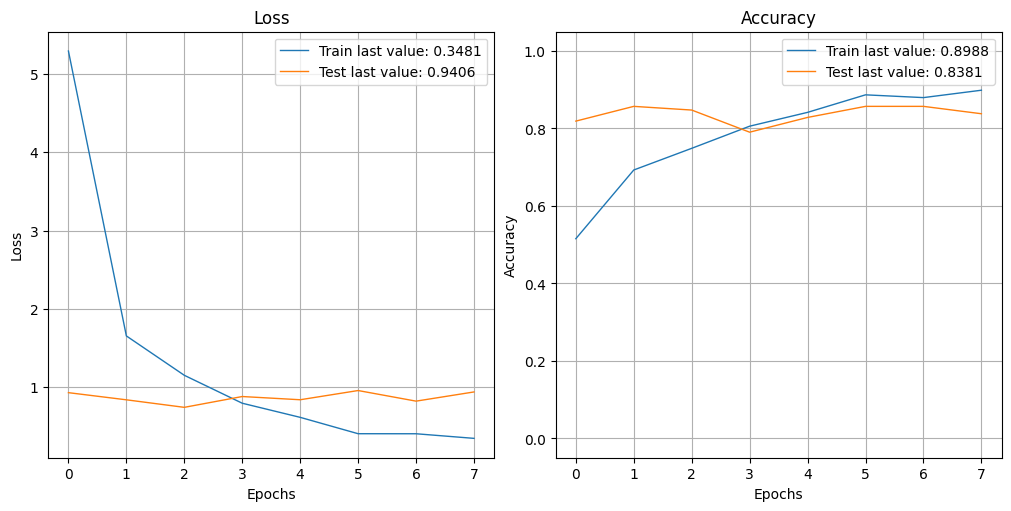

In [51]:
#Pour voir l'évolution de la perte et de l'accuracy des jeux d'entraînement et de validation en fonction de l'epoch
show_history(history3_vl)
plot_history(history3_vl, path="standard.png")
plt.close()

In [52]:
#On récupère les étiquettes des classes du test_dataset
y_test_num3 = []
for images, labels in test_dataset:
    y_test_num3.extend(np.argmax(labels.numpy(), axis=1))

y_test_num3 = np.array(y_test_num3)
print(y_test_num3)
print()

#On prédit les catégories sur le jeu de test
y_pred3_vl = np.argmax(model3_vl.predict(test_dataset), axis=1)
print(y_pred3_vl)

[1 6 2 1 2 0 3 1 6 1 6 2 3 1 4 4 4 6 6 4 5 6 1 6 0 1 2 4 0 3 1 6 4 3 2 5 6
 3 2 5 4 0 6 3 0 3 0 3 4 3 2 4 5 5 6 1 5 5 1 3 0 3 0 5 3 2 5 4 6 4 1 4 0 3
 1 4 6 5 0 3 2 3 5 0 0 1 5 0 3 3 4 5 5 1 3 2 0 4 5 2 6 6 5 4 5]

7/7 [==============================] - 2s 275ms/step
[1 6 2 4 2 4 3 4 6 1 6 2 3 1 4 4 4 6 6 4 5 6 1 6 4 2 2 4 4 3 1 6 4 5 2 3 6
 3 2 5 4 0 6 3 0 3 0 5 4 4 2 4 5 5 6 4 5 5 1 4 2 3 0 5 0 2 5 4 6 4 1 4 4 3
 1 4 6 5 1 3 2 6 1 5 0 4 5 0 3 2 4 5 5 1 3 2 0 4 5 2 6 6 5 4 1]


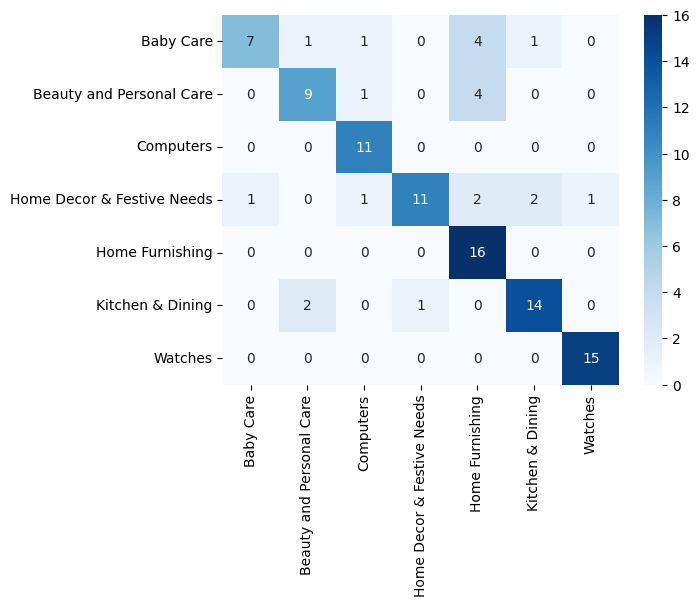

                            precision    recall  f1-score   support

                 Baby Care       0.88      0.50      0.64        14
  Beauty and Personal Care       0.75      0.64      0.69        14
                 Computers       0.79      1.00      0.88        11
Home Decor & Festive Needs       0.92      0.61      0.73        18
           Home Furnishing       0.62      1.00      0.76        16
          Kitchen & Dining       0.82      0.82      0.82        17
                   Watches       0.94      1.00      0.97        15

                  accuracy                           0.79       105
                 macro avg       0.81      0.80      0.79       105
              weighted avg       0.82      0.79      0.78       105



In [53]:
#Heatmap et classification report sur le jeu de test
conf_mat3_vl = metrics.confusion_matrix(y_test_num3, y_pred3_vl)
df_cm3_vl = pd.DataFrame(conf_mat3_vl, index=[label for label in test_dataset.class_names], columns=[label for label in test_dataset.class_names])
sns.heatmap(df_cm3_vl, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report3_vl = metrics.classification_report(y_test_num3, y_pred3_vl, target_names=test_dataset.class_names)
print(report3_vl)

## 2) ModelCheckpoint et EarlyStopping = val_accuracy <a class="anchor" id="iv2"></a>

In [54]:
#Création du modèle
model3_va = create_model_fct()

#Création du callback
#On cherche à maximiser l'accuracy
model3_va_save_path = "/content/drive/MyDrive/model3_va_best_weights.keras"
checkpoint = ModelCheckpoint(model3_va_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) #Arrête l'entraînement si la performance ne s'améliore pas après 5 epochs
callbacks_list = [checkpoint, es]

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [55]:
#On entraîne le modèle
start_time = time.time()
history3_va = model3_va.fit(train_dataset, epochs=50, batch_size=batch_size, callbacks=callbacks_list, validation_data=val_dataset, verbose=1)
end_time = time.time()

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 5.0110 - accuracy: 0.5202
Epoch 1: val_accuracy improved from -inf to 0.76190, saving model to /content/drive/MyDrive/model3_va_best_weights.keras
53/53 [==============================] - 23s 406ms/step - loss: 5.0110 - accuracy: 0.5202 - val_loss: 1.2713 - val_accuracy: 0.7619
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 1.8507 - accuracy: 0.7262
Epoch 2: val_accuracy improved from 0.76190 to 0.79048, saving model to /content/drive/MyDrive/model3_va_best_weights.keras
53/53 [==============================] - 19s 344ms/step - loss: 1.8507 - accuracy: 0.7262 - val_loss: 0.8810 - val_accuracy: 0.7905
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 1.2648 - accuracy: 0.7690
Epoch 3: val_accuracy improved from 0.79048 to 0.81905, saving model to /content/drive/MyDrive/model3_va_best_weights.keras
53/53 [==============================] - 19s 338ms/step - loss: 1.2648 - accuracy: 0.

In [56]:
#On enregistre le temps d'entraînement et le nombre d'epochs
durée3_va = end_time - start_time
durée3_va = str(timedelta(seconds=int(durée3_va)))
print(f"Temps d'entraînement : {durée3_va}")
nb_epochs3_va = es.stopped_epoch
print(f"Nombre d'epochs : {nb_epochs3_va}")

Temps d'entraînement : 0:04:23
Nombre d'epochs : 13


In [57]:
#On enregistre les résultats
evaluation_et_resultats(model3_va, model3_va_save_path, "model3_va", nb_epochs3_va, durée3_va)

7/7 [==============================] - 2s 271ms/step - loss: 1.1908 - accuracy: 0.8286


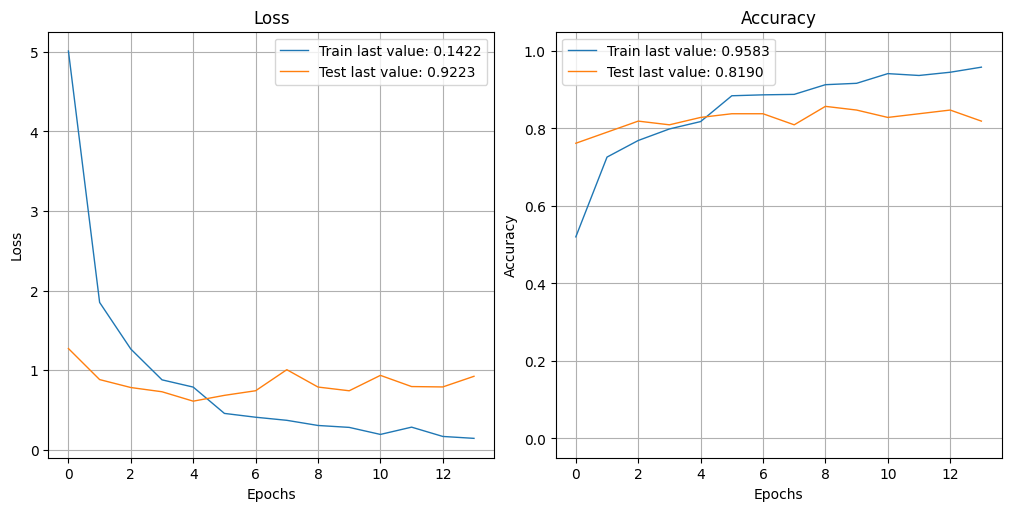

In [58]:
#Pour voir l'évolution de la perte et de l'accuracy des jeux d'entraînement et de validation en fonction de l'epoch
show_history(history3_va)
plot_history(history3_va, path="standard.png")
plt.close()

In [59]:
#On prédit les catégories sur le jeu de test
y_pred3_va = np.argmax(model3_va.predict(test_dataset), axis=1)
print(y_pred3_va)

7/7 [==============================] - 2s 267ms/step
[1 6 2 1 2 0 3 4 6 1 6 2 3 1 4 4 4 6 6 4 5 6 1 6 0 5 2 4 4 3 1 6 4 5 2 0 6
 3 2 5 4 0 6 0 0 3 0 6 4 4 2 4 5 5 6 4 5 5 1 3 5 3 1 5 3 2 5 4 6 4 1 4 4 3
 1 4 6 5 1 3 2 6 0 5 0 3 5 0 3 3 4 5 5 1 3 2 0 4 3 2 6 6 5 4 5]


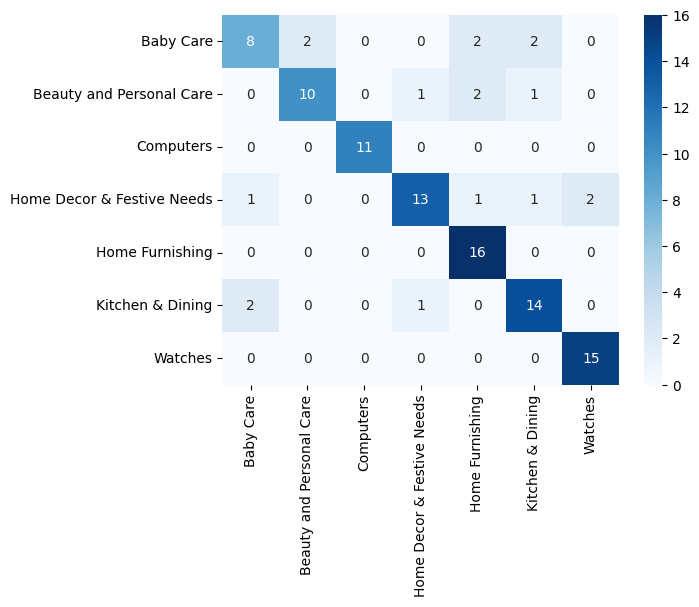

                            precision    recall  f1-score   support

                 Baby Care       0.73      0.57      0.64        14
  Beauty and Personal Care       0.83      0.71      0.77        14
                 Computers       1.00      1.00      1.00        11
Home Decor & Festive Needs       0.87      0.72      0.79        18
           Home Furnishing       0.76      1.00      0.86        16
          Kitchen & Dining       0.78      0.82      0.80        17
                   Watches       0.88      1.00      0.94        15

                  accuracy                           0.83       105
                 macro avg       0.84      0.83      0.83       105
              weighted avg       0.83      0.83      0.82       105



In [60]:
#Heatmap et classification report sur le jeu de test
conf_mat3_va = metrics.confusion_matrix(y_test_num3, y_pred3_va)
df_cm3_va = pd.DataFrame(conf_mat3_va, index=[label for label in test_dataset.class_names], columns=[label for label in test_dataset.class_names])
sns.heatmap(df_cm3_va, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report3_va = metrics.classification_report(y_test_num3, y_pred3_va, target_names=test_dataset.class_names)
print(report3_va)

Et on termine de nouveau avec data augmentation.
# V) 4ème modèle : Approche par Dataset avec data augmentation <a class="anchor" id="v"></a>

In [61]:
#On utilise les mêmes datasets que lors de l'approche précédente
#Mais on définit une nouvelle fonction pour inclure la data augmentation lors de la création du modèle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Rescaling

def create_model_fct2() :
    #Data augmentation
    data_augmentation = Sequential([RandomFlip("horizontal", input_shape=(224, 224, 3)), #Flip horizontal
                                    RandomRotation(0.2), #20% de rotation (de -36 à +36 degrés)
                                    RandomZoom(0.2), #20% de zoom
                                    RandomTranslation(0.2, 0.2)]) #20% de translation horizontale et verticale

    #On récupère le modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    #On définit le nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax') #Dernière couche avec 7 neurones (7 classes à prédire)
                ])

    #On compile
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model

Toujours là ? On voit bientôt le bout !
## 1) ModelCheckpoint et EarlyStopping = val_loss <a class="anchor" id="v1"></a>

In [62]:
#Création du modèle
model4_vl = create_model_fct2()

#Création du callback
#On cherche à minimiser la perte
model4_vl_save_path = "/content/drive/MyDrive/model4_vl_best_weights.keras"
checkpoint = ModelCheckpoint(model4_vl_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #Arrête l'entraînement si la performance ne s'améliore pas après 5 epochs
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_6  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                      

In [63]:
#On entraîne le modèle
start_time = time.time()
history4_vl = model4_vl.fit(train_dataset, epochs=50, batch_size=batch_size, callbacks=callbacks_list, validation_data=val_dataset, verbose=1)
end_time = time.time()

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 1.7401 - accuracy: 0.3440
Epoch 1: val_loss improved from inf to 1.24219, saving model to /content/drive/MyDrive/model4_vl_best_weights.keras
53/53 [==============================] - 24s 430ms/step - loss: 1.7401 - accuracy: 0.3440 - val_loss: 1.2422 - val_accuracy: 0.7143
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 1.3660 - accuracy: 0.5250
Epoch 2: val_loss improved from 1.24219 to 0.94571, saving model to /content/drive/MyDrive/model4_vl_best_weights.keras
53/53 [==============================] - 19s 351ms/step - loss: 1.3660 - accuracy: 0.5250 - val_loss: 0.9457 - val_accuracy: 0.7524
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 1.2023 - accuracy: 0.5964
Epoch 3: val_loss improved from 0.94571 to 0.80977, saving model to /content/drive/MyDrive/model4_vl_best_weights.keras
53/53 [==============================] - 19s 355ms/step - loss: 1.2023 - accuracy: 0.5964 - val_lo

In [64]:
#On enregistre le temps d'entraînement et le nombre d'epochs
durée4_vl = end_time - start_time
durée4_vl = str(timedelta(seconds=int(durée4_vl)))
print(f"Temps d'entraînement : {durée4_vl}")
nb_epochs4_vl = es.stopped_epoch
print(f"Nombre d'epochs : {nb_epochs4_vl}")

Temps d'entraînement : 0:12:14
Nombre d'epochs : 37


In [65]:
#On enregistre les résultats
evaluation_et_resultats(model4_vl, model4_vl_save_path, "model4_vl", nb_epochs4_vl, durée4_vl)

7/7 [==============================] - 2s 278ms/step - loss: 0.6689 - accuracy: 0.7810


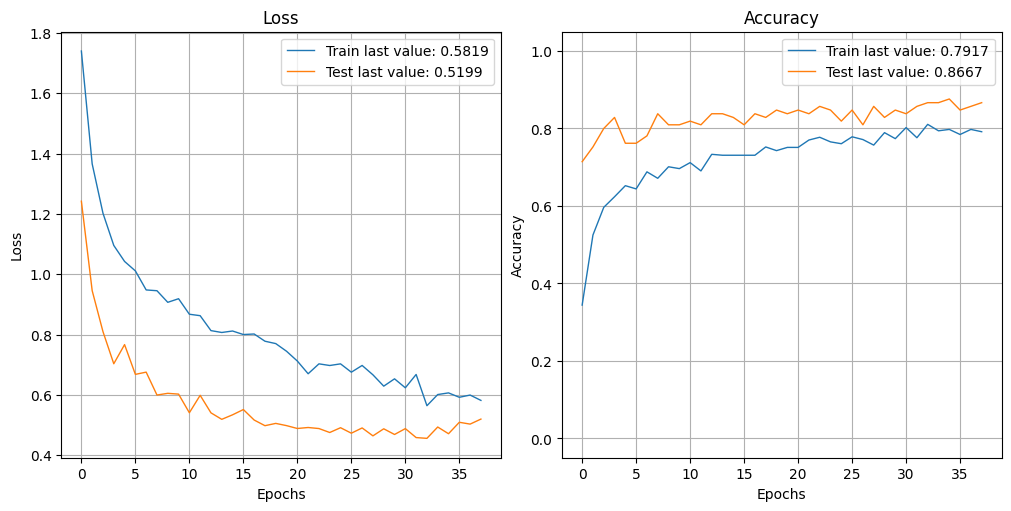

In [66]:
#Pour voir l'évolution de la perte et de l'accuracy des jeux d'entraînement et de validation en fonction de l'epoch
show_history(history4_vl)
plot_history(history4_vl, path="standard.png")
plt.close()

In [67]:
#On récupère les étiquettes des classes du test_dataset
y_test_num4 = []
for images, labels in test_dataset:
    y_test_num4.extend(np.argmax(labels.numpy(), axis=1))

y_test_num4 = np.array(y_test_num4)
print(y_test_num4)
print()

#On prédit les catégories sur le jeu de test
y_pred4_vl = np.argmax(model4_vl.predict(test_dataset), axis=1)
print(y_pred4_vl)

[1 6 2 1 2 0 3 1 6 1 6 2 3 1 4 4 4 6 6 4 5 6 1 6 0 1 2 4 0 3 1 6 4 3 2 5 6
 3 2 5 4 0 6 3 0 3 0 3 4 3 2 4 5 5 6 1 5 5 1 3 0 3 0 5 3 2 5 4 6 4 1 4 0 3
 1 4 6 5 0 3 2 3 5 0 0 1 5 0 3 3 4 5 5 1 3 2 0 4 5 2 6 6 5 4 5]

7/7 [==============================] - 2s 271ms/step
[1 6 2 0 2 0 3 0 6 1 6 2 5 1 4 4 4 6 6 4 5 6 1 6 0 1 2 4 4 3 1 6 4 5 2 4 6
 3 2 5 4 0 6 3 0 3 0 6 4 0 2 4 5 5 6 0 5 5 1 3 5 0 0 5 3 2 5 2 6 4 1 4 4 3
 1 4 2 5 1 3 2 6 1 5 0 0 5 0 3 1 4 5 5 1 2 2 0 4 5 2 6 6 5 0 1]


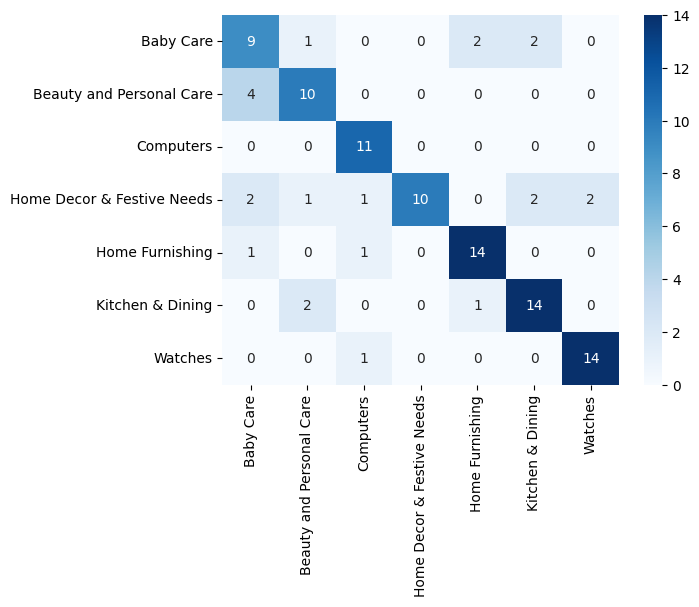

                            precision    recall  f1-score   support

                 Baby Care       0.56      0.64      0.60        14
  Beauty and Personal Care       0.71      0.71      0.71        14
                 Computers       0.79      1.00      0.88        11
Home Decor & Festive Needs       1.00      0.56      0.71        18
           Home Furnishing       0.82      0.88      0.85        16
          Kitchen & Dining       0.78      0.82      0.80        17
                   Watches       0.88      0.93      0.90        15

                  accuracy                           0.78       105
                 macro avg       0.79      0.79      0.78       105
              weighted avg       0.80      0.78      0.78       105



In [68]:
#Heatmap et classification report sur le jeu de test
conf_mat4_vl = metrics.confusion_matrix(y_test_num4, y_pred4_vl)
df_cm4_vl = pd.DataFrame(conf_mat4_vl, index=[label for label in test_dataset.class_names], columns=[label for label in test_dataset.class_names])
sns.heatmap(df_cm4_vl, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report4_vl = metrics.classification_report(y_test_num4, y_pred4_vl, target_names=test_dataset.class_names)
print(report4_vl)

## 2) ModelCheckpoint et EarlyStopping = val_accuracy <a class="anchor" id="v2"></a>

In [69]:
#Création du modèle
model4_va = create_model_fct2()

#Création du callback
#On cherche à maximiser l'accuracy
model4_va_save_path = "/content/drive/MyDrive/model4_va_best_weights.keras"
checkpoint = ModelCheckpoint(model4_va_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) #Arrête l'entraînement si la performance ne s'améliore pas après 5 epochs
callbacks_list = [checkpoint, es]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_7  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

In [70]:
#On entraîne le modèle
start_time = time.time()
history4_va = model4_va.fit(train_dataset, epochs=50, batch_size=batch_size, callbacks=callbacks_list, validation_data=val_dataset, verbose=1)
end_time = time.time()

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 1.7347 - accuracy: 0.3405
Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to /content/drive/MyDrive/model4_va_best_weights.keras
53/53 [==============================] - 24s 431ms/step - loss: 1.7347 - accuracy: 0.3405 - val_loss: 1.2235 - val_accuracy: 0.7333
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 1.3664 - accuracy: 0.5310
Epoch 2: val_accuracy improved from 0.73333 to 0.74286, saving model to /content/drive/MyDrive/model4_va_best_weights.keras
53/53 [==============================] - 20s 356ms/step - loss: 1.3664 - accuracy: 0.5310 - val_loss: 0.9756 - val_accuracy: 0.7429
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 1.2034 - accuracy: 0.5869
Epoch 3: val_accuracy improved from 0.74286 to 0.80952, saving model to /content/drive/MyDrive/model4_va_best_weights.keras
53/53 [==============================] - 19s 347ms/step - loss: 1.2034 - accuracy: 0.

In [71]:
#On enregistre le temps d'entraînement et le nombre d'epochs
durée4_va = end_time - start_time
durée4_va = str(timedelta(seconds=int(durée4_va)))
print(f"Temps d'entraînement : {durée4_va}")
nb_epochs4_va = es.stopped_epoch
print(f"Nombre d'epochs : {nb_epochs4_va}")

Temps d'entraînement : 0:04:15
Nombre d'epochs : 12


In [72]:
#On enregistre les résultats
evaluation_et_resultats(model4_va, model4_va_save_path, "model4_va", nb_epochs4_va, durée4_va)

7/7 [==============================] - 2s 284ms/step - loss: 0.7972 - accuracy: 0.7905


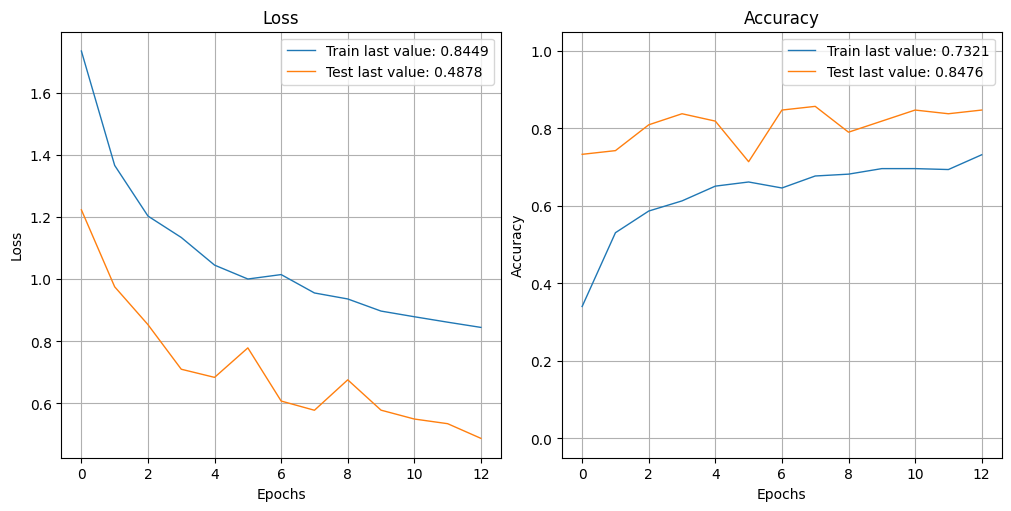

In [73]:
#Pour voir l'évolution de la perte et de l'accuracy des jeux d'entraînement et de validation en fonction de l'epoch
show_history(history4_va)
plot_history(history4_va, path="standard.png")
plt.close()

In [74]:
#On prédit les catégories sur le jeu de test
y_pred4_va = np.argmax(model4_va.predict(test_dataset), axis=1)
print(y_pred4_va)

7/7 [==============================] - 2s 288ms/step
[1 6 1 4 2 0 3 4 6 1 6 2 5 1 4 4 4 6 6 4 5 6 1 6 0 1 2 4 4 3 1 6 4 5 2 5 6
 3 2 5 4 0 6 3 0 3 0 3 4 0 2 4 5 5 6 1 5 5 1 3 5 0 0 5 3 2 5 2 6 4 1 4 4 3
 1 4 2 5 1 3 2 6 1 5 0 4 5 0 3 1 4 5 5 1 2 1 0 4 5 2 6 6 5 0 2]


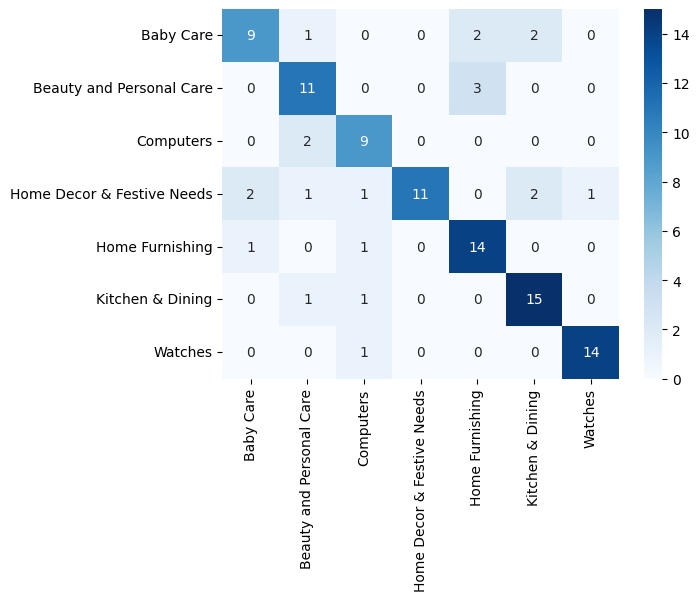

                            precision    recall  f1-score   support

                 Baby Care       0.75      0.64      0.69        14
  Beauty and Personal Care       0.69      0.79      0.73        14
                 Computers       0.69      0.82      0.75        11
Home Decor & Festive Needs       1.00      0.61      0.76        18
           Home Furnishing       0.74      0.88      0.80        16
          Kitchen & Dining       0.79      0.88      0.83        17
                   Watches       0.93      0.93      0.93        15

                  accuracy                           0.79       105
                 macro avg       0.80      0.79      0.79       105
              weighted avg       0.81      0.79      0.79       105



In [75]:
#Heatmap et classification report sur le jeu de test
conf_mat4_va = metrics.confusion_matrix(y_test_num4, y_pred4_va)
df_cm4_va = pd.DataFrame(conf_mat4_va, index=[label for label in test_dataset.class_names], columns=[label for label in test_dataset.class_names])
sns.heatmap(df_cm4_va, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report4_va = metrics.classification_report(y_test_num4, y_pred4_va, target_names=test_dataset.class_names)
print(report4_va)

# VI) Résultats <a class="anchor" id="vi"></a>

In [76]:
#On affiche les résultats pour comparer les différents modèles
resultats_df = pd.DataFrame(resultats)
resultats_df

,modèles,nb_epochs,loss_val,accuracy_val,loss_test,accuracy_test,temps_train
0,model1_vl,10,0.672587,0.838095,1.937322,0.771429,0:03:16
1,model1_va,13,0.743175,0.885714,1.754850,0.809524,0:04:12
2,model2_vl,8,1.170134,0.771429,0.926492,0.761905,0:04:39
3,model2_va,19,1.262857,0.809524,0.934943,0.819048,0:10:13
4,model3_vl,7,0.744005,0.847619,1.274305,0.790476,0:02:32
5,model3_va,13,0.787176,0.857143,1.190814,0.828571,0:04:23
6,model4_vl,37,0.456038,0.866667,0.668925,0.780952,0:12:14
7,model4_va,12,0.578223,0.857143,0.797220,0.790476,0:04:15


In [77]:
resultats_df.to_csv('resultats_df.csv', index=False)

# Conclusion <a class="anchor" id="conclusion"></a>

Compte tenu des résultats des différents modèles, il me semble évident que la 4ème approche est à privilégier. Seulement, le modèle cherchant à minimiser la fonction de perte renvoie un nombre d'epochs optimal de 37, ce qui me parait énorme, avec un temps d'entraînement étant également relativement long. Je serais plutôt tenté de recommander de chercher à maximiser l'accuracy. Les résultats sont peut-être légèrement moins bon, mais le nombre d'épochs et temps d'entraînement me semblent plus raisonnables.